In [1]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [98]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

import itertools
import scipy.stats

import time

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
data = pd.read_csv('data/rice-cammeo-osmanick.csv')

y = data.CLASS
X = data.drop(['CLASS'], axis=1)
y = y.values
y[y == 'Cammeo'] = 0
y[y == 'Osmancik'] = 1
y = y.astype(int)

print("Number of samples:", y.size)
print("Percentage of Osmancik cases:", y[y==1].size/y.size*100)

print("Splitting into train/test sets...")
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Setting up global variables...")
classifier_accuracy = np.zeros(6)
time_train = np.zeros(6)
time_infer = np.zeros(6)

Number of samples: 3810
Percentage of Osmancik cases: 57.21784776902887
Splitting into train/test sets...
Setting up global variables...


# Clustering

## K-Means

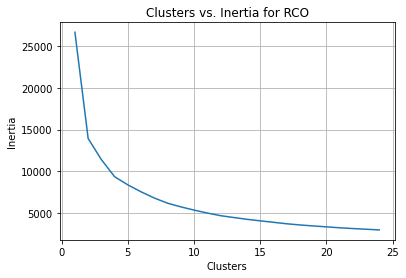

In [147]:
range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO')
plt.grid()
plt.savefig('rice_kmeans_inertia.png')
plt.show()

For n_clusters = 4 The average silhouette_score is : 0.2708076251558966


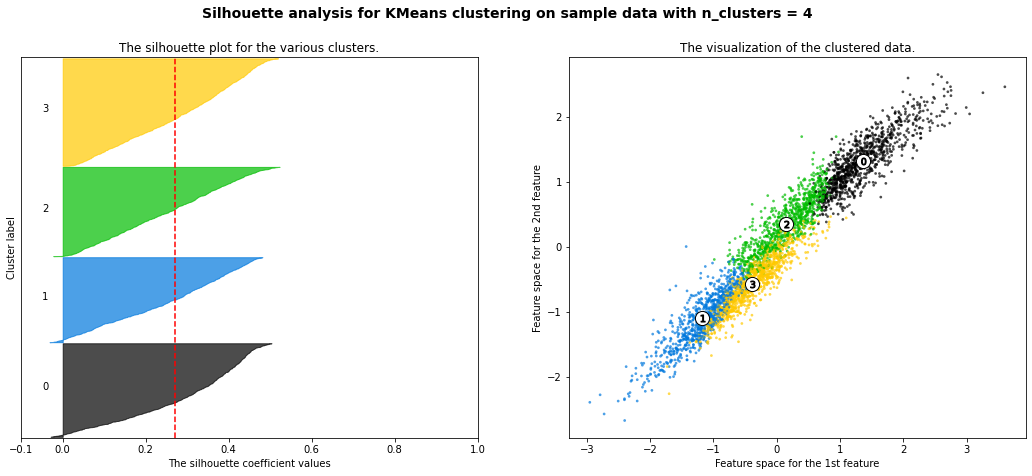

In [148]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

range_n_clusters = np.arange(4, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.savefig('rice_kmeans_silhouette.png')
plt.show()

Inertia:  9352.662703236967
Silhouette score:  0.27070992598198584
Adjusted Mutual Information (AMI) score:  0.3096097905371932


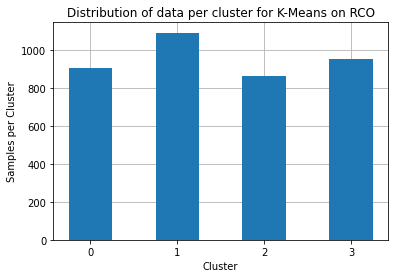

In [149]:
k = 4
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit(X)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(X, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO')
plt.grid()

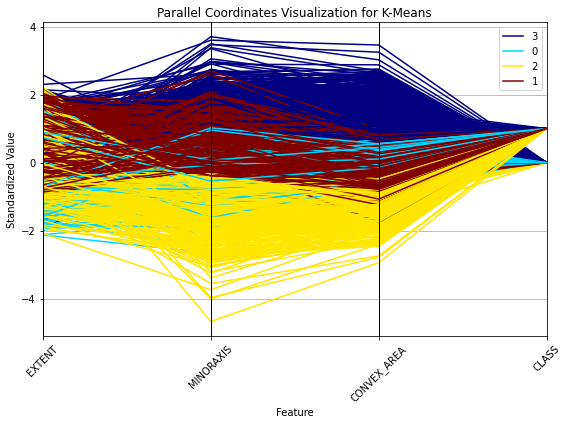

In [150]:
np.random.seed(40)
cols = data.drop(['CLASS'], axis=1).columns
data_viz = pd.DataFrame(X, columns = cols)
data_viz['CLASS'] = y
data_viz['cluster_class'] = k_means_clustering.labels_

idx_viz = np.append(np.random.randint(0, data_viz.shape[1] - 2, 3), [data_viz.shape[1] - 2, data_viz.shape[1] - 1]) 

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for K-Means')
plt.savefig('rice_kmeans_parallel_coordinates.png')
plt.tight_layout()

In [153]:
for i in range(max(k_means_clustering.labels_)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

0    635
1    271
Name: CLASS, dtype: int64
1    1047
0      44
Name: CLASS, dtype: int64
1    837
0     26
Name: CLASS, dtype: int64
0    925
1     25
Name: CLASS, dtype: int64


## EM (GMM)

In [139]:
lowest_bic = np.infty
num_components_values = range(1, 20)
covariances = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(covariances),len(num_components_values)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(X)
        bic[i][j] = gmm.bic(X)
        if bic[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm = gmm

Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 7
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for spherical 11
Lowest BIC currently for spherical 12
Lowest BIC currently for spherical 13
Lowest BIC currently for spherical 14
Lowest BIC currently for spherical 15
Lowest BIC currently for spherical 16
Lowest BIC currently for spherical 17
Lowest BIC currently for spherical 19
Lowest BIC currently for tied 1
Lowest BIC currently for tied 2
Lowest BIC currently for tied 3
Lowest BIC currently for tied 4
Lowest BIC currently for tied 5
Lowest BIC currently for tied 6
Lowest BIC currently for tied 8
Lowest BIC currently for tied 9
Lowest BIC currently for tied 10
Lowest BIC currently for tied 11
Low

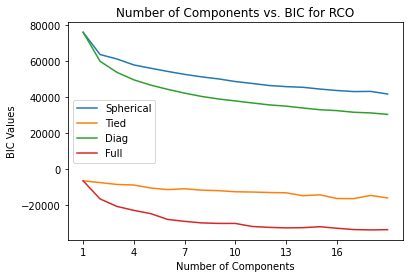

In [140]:
plt.figure()
plt.plot(num_components_values, bic[0], label = 'Spherical')
plt.plot(num_components_values, bic[1], label = 'Tied')
plt.plot(num_components_values, bic[2], label = 'Diag')
plt.plot(num_components_values, bic[3], label = 'Full')
plt.legend()
plt.xticks(np.arange(1,num_components_values[-1],3))
plt.title("Number of Components vs. BIC for RCO")
plt.xlabel("Number of Components")
plt.ylabel("BIC Values")
plt.savefig('rice_gmm_bic.png')
plt.show()

For n_clusters = 6 The average silhouette_score is : 0.06162656230319786


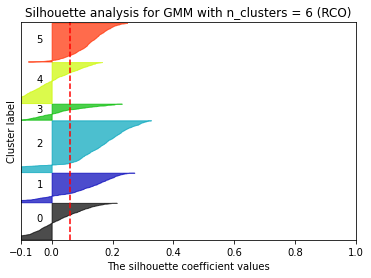

In [141]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

range_n_clusters = np.arange(6, 7, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
#     fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette analysis for GMM with n_clusters = %d (RCO)" % n_clusters)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.savefig('rice_gmm_silhouette.png')
plt.show()

Silhouette score:  0.03882276872758973
Adjusted Mutual Information (AMI) score:  0.22242105259312311


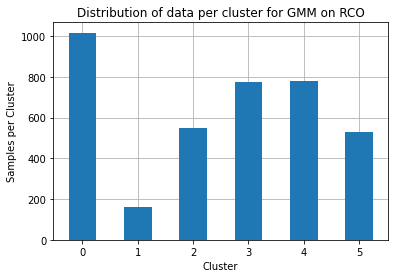

In [142]:
best_gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
best_gmm.fit(X)
gmm_labels = best_gmm.predict(X)
silhouette_score_value = silhouette_score(X, gmm_labels)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, gmm_labels)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(gmm_labels, bins=np.arange(0, 7) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, 6))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for GMM on RCO')
plt.grid()

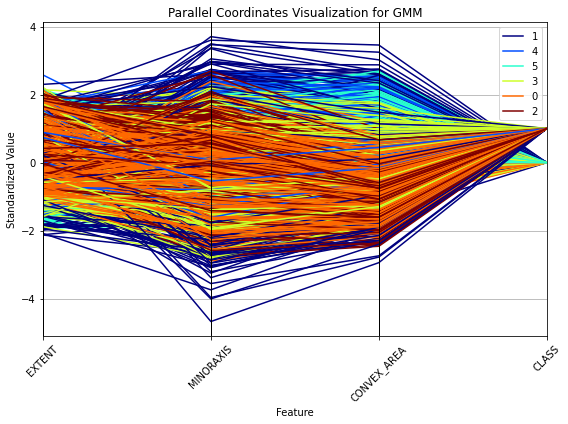

In [155]:
np.random.seed(40)
cols = data.drop(['CLASS'], axis=1).columns
data_viz = pd.DataFrame(X, columns = cols)
data_viz['CLASS'] = y
data_viz['cluster_class'] = gmm_labels

idx_viz = np.append(np.random.randint(0, data_viz.shape[1] - 2, 3), [data_viz.shape[1] - 2, data_viz.shape[1] - 1]) 

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for GMM')
plt.savefig('rice_gmm_parallel_coordinates.png')
plt.tight_layout()

In [156]:
for i in range(max(gmm_labels)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

1    983
0     34
Name: CLASS, dtype: int64
0    99
1    61
Name: CLASS, dtype: int64
1    547
0      4
Name: CLASS, dtype: int64
1    469
0    305
Name: CLASS, dtype: int64
0    671
1    108
Name: CLASS, dtype: int64
0    517
1     12
Name: CLASS, dtype: int64


In [157]:
99/(99+61)

0.61875

In [158]:
469/(469+305)

0.6059431524547804

# Dimensionality Reduction

## PCA

In [162]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

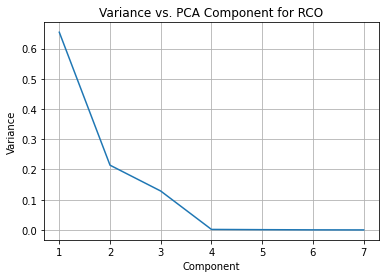

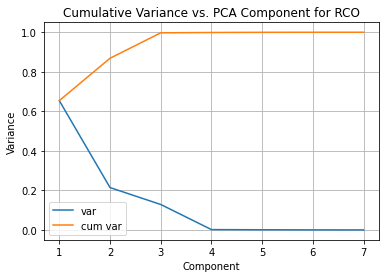

In [175]:
plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Variance vs. PCA Component for RCO')
plt.grid()

plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_, label='var')
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_), label='cum var')
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Cumulative Variance vs. PCA Component for RCO')
plt.legend()
plt.grid()
plt.savefig('rice_pca_variance.png')

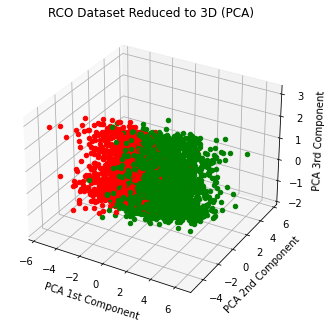

In [164]:
X_PCA_3D = PCA(n_components = 3).fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(y)):
    if y[i] == 0:
        ax.scatter(X_PCA_3D[i, :][0], X_PCA_3D[i, :][1], X_PCA_3D[i, :][2], c = 'g', marker='o', label='0')
    elif y[i] == 1:
        ax.scatter(X_PCA_3D[i, :][0], X_PCA_3D[i, :][1], X_PCA_3D[i, :][2], c = 'r', marker='o', label='1')
ax.set_xlabel('PCA 1st Component')
ax.set_ylabel('PCA 2nd Component')
ax.set_zlabel('PCA 3rd Component')
plt.title('RCO Dataset Reduced to 3D (PCA)')
plt.show()

In [165]:
X_PCA = PCA(n_components = 3).fit_transform(X)

## ICA

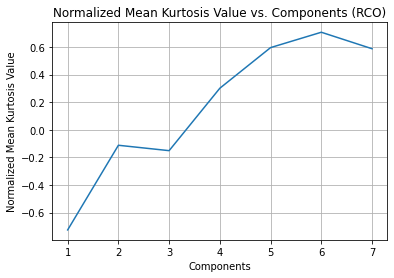

In [167]:
kurtosis_values = []
for i in range(1,8):
    X_ICA = FastICA(n_components = i).fit_transform(X)
    kur = scipy.stats.kurtosis(X_ICA)
    kurtosis_values.append(np.mean(kur)/i)
kurtosis_values = np.array(kurtosis_values)
plt.plot(np.arange(1,8),kurtosis_values)
plt.xlabel('Components')
plt.ylabel('Normalized Mean Kurtosis Value')
plt.title('Normalized Mean Kurtosis Value vs. Components (RCO)')
plt.grid()
plt.savefig('rice_ica_kurtosis.png')
plt.show()

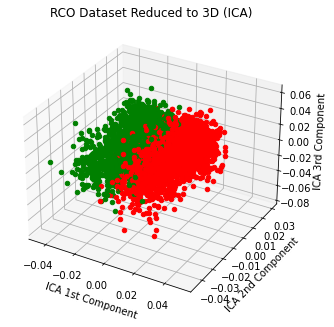

In [168]:
X_ICA_3D = FastICA(n_components = 3).fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(y)):
    if y[i] == 0:
        ax.scatter(X_ICA_3D[i, :][0], X_ICA_3D[i, :][1], X_ICA_3D[i, :][2], c = 'g', marker='o', label='0')
    elif y[i] == 1:
        ax.scatter(X_ICA_3D[i, :][0], X_ICA_3D[i, :][1], X_ICA_3D[i, :][2], c = 'r', marker='o', label='1')
ax.set_xlabel('ICA 1st Component')
ax.set_ylabel('ICA 2nd Component')
ax.set_zlabel('ICA 3rd Component')
plt.title('RCO Dataset Reduced to 3D (ICA)')
plt.show()

In [169]:
X_ICA = FastICA(n_components = np.argmax(kurtosis_values)+1).fit_transform(X)

## RP

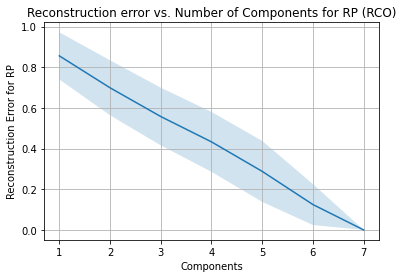

In [174]:
reconstruction_error = []
reconstruction_variance = []
for i in range(1,8):
    mean_mse = []
    for j in range(0,100):
        rp = GaussianRandomProjection(n_components=i)
        X_RP = rp.fit(X)
        w = X_RP.components_
        p = pinv(w)
        reconstructed = ((p@w)@(X.T)).T
        mean_mse.append(mean_squared_error(X,reconstructed))
    reconstruction_variance.append(np.std(mean_mse))
    reconstruction_error.append(np.mean(mean_mse))

reconstruction_error = np.array(reconstruction_error)
plt.plot(np.arange(1,8),reconstruction_error)
plt.fill_between(np.arange(1,8),reconstruction_error - reconstruction_variance, reconstruction_error + reconstruction_variance, alpha=0.2)
plt.xlabel('Components')
plt.ylabel('Reconstruction Error for RP')
plt.title('Reconstruction error vs. Number of Components for RP (RCO)')
plt.grid()
plt.savefig('rice_rp_error.png')
plt.show()

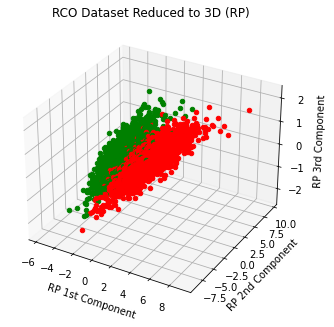

In [171]:
X_RP_3D = GaussianRandomProjection(n_components = 3).fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(y)):
    if y[i] == 0:
        ax.scatter(X_RP_3D[i, :][0], X_RP_3D[i, :][1], X_RP_3D[i, :][2], c = 'g', marker='o', label='0')
    elif y[i] == 1:
        ax.scatter(X_RP_3D[i, :][0], X_RP_3D[i, :][1], X_RP_3D[i, :][2], c = 'r', marker='o', label='1')
ax.set_xlabel('RP 1st Component')
ax.set_ylabel('RP 2nd Component')
ax.set_zlabel('RP 3rd Component')
plt.title('RCO Dataset Reduced to 3D (RP)')
plt.show()

In [188]:
X_RP = GaussianRandomProjection(n_components = 3).fit_transform(X)

## Feature Selection using Trees

In [205]:
etc = ExtraTreesClassifier(n_estimators = 100)
etc = etc.fit(X,y)
print(etc.feature_importances_)
model = SelectFromModel(etc, prefit=True)
X_Trees = model.transform(X)
model.get_support()

[0.20220435 0.22339589 0.24605164 0.0487113  0.08224204 0.1623851
 0.03500967]


array([ True,  True,  True, False, False,  True, False])

# Clustering with Dimensionality Reduction

## K-Means

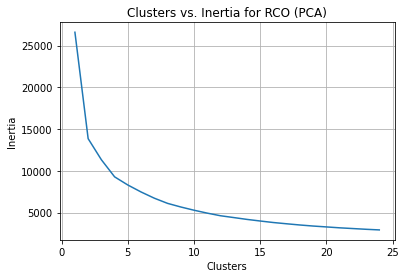

In [179]:
range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X_PCA)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('rice_inertia_pca.png')
plt.show()

Inertia:  9279.931942417401
Silhouette score:  0.2722544033604858
Adjusted Mutual Information (AMI) score:  0.30963361923491345


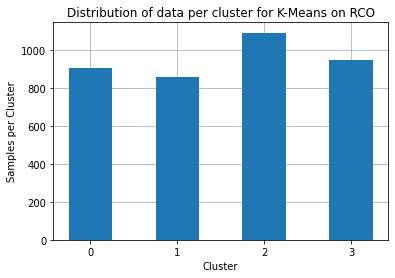

In [180]:
k = 4
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit(X_PCA)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(X_PCA, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO')
plt.grid()

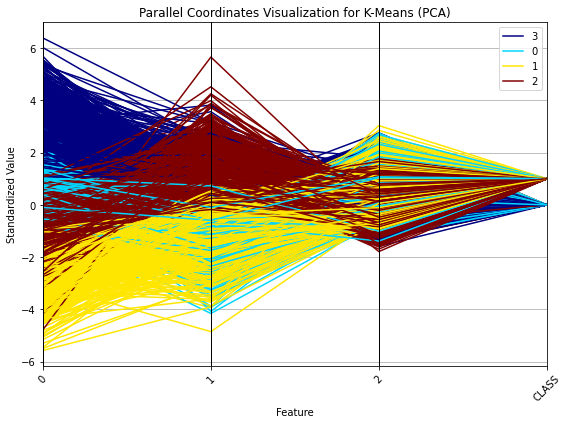

In [181]:
np.random.seed(43)
data_viz = pd.DataFrame(X_PCA)
data_viz['CLASS'] = y
data_viz['cluster_class'] = k_means_clustering.labels_

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1]) 

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for K-Means (PCA)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_pca.png')

In [182]:
for i in range(max(k_means_clustering.labels_)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

0    635
1    271
Name: CLASS, dtype: int64
1    835
0     26
Name: CLASS, dtype: int64
1    1049
0      44
Name: CLASS, dtype: int64
0    925
1     25
Name: CLASS, dtype: int64


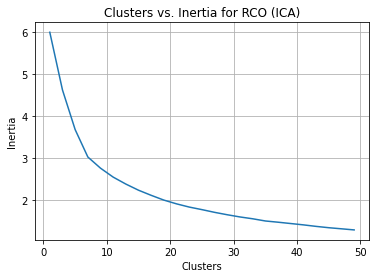

In [183]:
range_n_clusters = np.arange(1,50,2)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X_ICA)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (ICA)')
plt.grid()
plt.savefig('rice_inertia_ica.png')
plt.show()

Inertia:  3.0203171282818526
Silhouette score:  0.18023747894892056
Adjusted Mutual Information (AMI) score:  0.1344584123819519


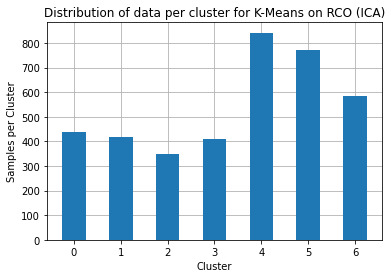

In [184]:
k = 7
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit(X_ICA)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(X_ICA, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO (ICA)')
plt.grid()

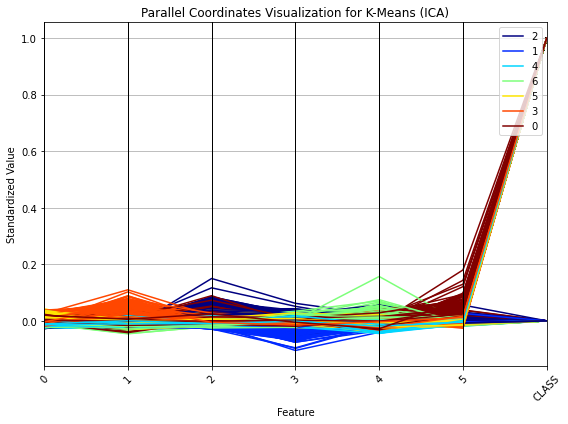

In [185]:
np.random.seed(43)
data_viz = pd.DataFrame(X_ICA)
data_viz['CLASS'] = y
data_viz['cluster_class'] = k_means_clustering.labels_

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1]) 

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for K-Means (ICA)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_ica.png')

In [186]:
for i in range(max(k_means_clustering.labels_)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

1    434
0      4
Name: CLASS, dtype: int64
0    411
1      5
Name: CLASS, dtype: int64
0    329
1     19
Name: CLASS, dtype: int64
1    405
0      5
Name: CLASS, dtype: int64
1    528
0    314
Name: CLASS, dtype: int64
1    449
0    321
Name: CLASS, dtype: int64
1    340
0    246
Name: CLASS, dtype: int64


In [199]:
528/842



0.6270783847980997

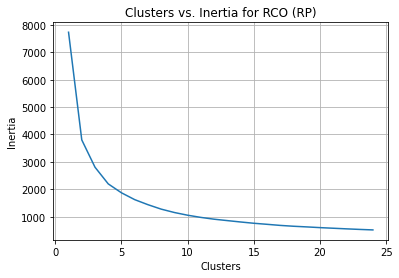

In [189]:
range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X_RP)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (RP)')
plt.grid()
plt.savefig('rice_inertia_rp.png')
plt.show()

Inertia:  2198.015635856341
Silhouette score:  0.34085138535771264
Adjusted Mutual Information (AMI) score:  0.21139632725464638


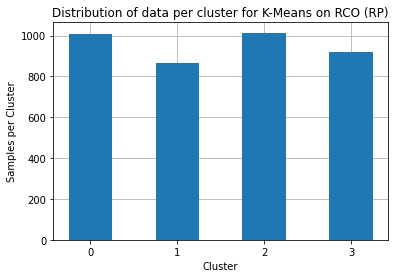

In [190]:
k = 4
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit(X_RP)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(X_RP, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO (RP)')
plt.grid()

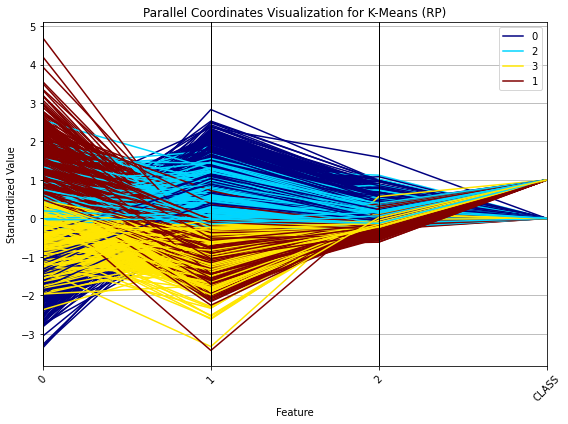

In [191]:
np.random.seed(43)
data_viz = pd.DataFrame(X_RP)
data_viz['CLASS'] = y
data_viz['cluster_class'] = k_means_clustering.labels_

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1]) 

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for K-Means (RP)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_rp.png')

In [192]:
for i in range(max(k_means_clustering.labels_)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

0    953
1     56
Name: CLASS, dtype: int64
1    815
0     52
Name: CLASS, dtype: int64
1    516
0    498
Name: CLASS, dtype: int64
1    793
0    127
Name: CLASS, dtype: int64


In [200]:
516/(516+498)

0.5088757396449705

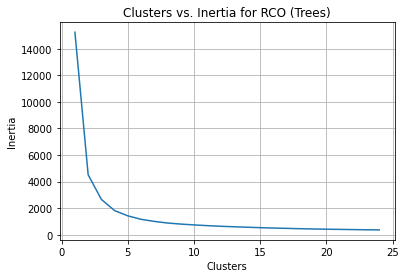

In [193]:
range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X_Trees)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (Trees)')
plt.grid()
plt.savefig('rice_inertia_trees.png')
plt.show()

Inertia:  1812.336997347932
Silhouette score:  0.4428207302418076
Adjusted Mutual Information (AMI) score:  0.31147169804455055


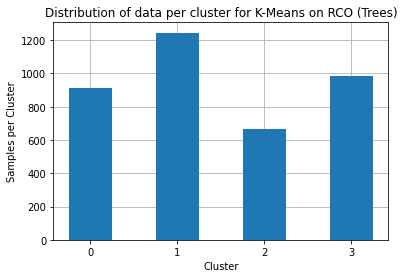

In [194]:
k = 4
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit(X_Trees)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(X_Trees, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO (Trees)')
plt.grid()

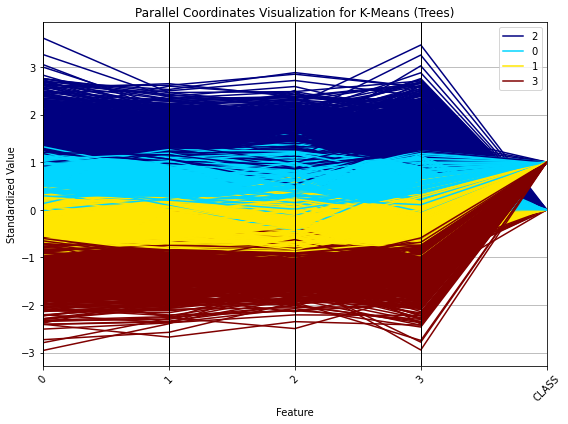

In [195]:
np.random.seed(43)
data_viz = pd.DataFrame(X_Trees)
data_viz['CLASS'] = y
data_viz['cluster_class'] = k_means_clustering.labels_

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1]) 

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for K-Means (Trees)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_trees.png')

In [196]:
for i in range(max(k_means_clustering.labels_)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

0    778
1    135
Name: CLASS, dtype: int64
1    1062
0     183
Name: CLASS, dtype: int64
0    661
1      6
Name: CLASS, dtype: int64
1    977
0      8
Name: CLASS, dtype: int64


In [201]:
778/(778+135)

0.8521358159912377

## EM (GMM)

In [206]:
lowest_bic = np.infty
num_components_values = range(1, 20)
covariances = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(covariances),len(num_components_values)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(X_PCA)
        bic[i][j] = gmm.bic(X_PCA)
        if bic[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm = gmm

Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for spherical 12
Lowest BIC currently for spherical 15
Lowest BIC currently for spherical 16
Lowest BIC currently for spherical 17
Lowest BIC currently for spherical 18
Lowest BIC currently for tied 6
Lowest BIC currently for tied 7
Lowest BIC currently for tied 9
Lowest BIC currently for tied 11
Lowest BIC currently for tied 12
Lowest BIC currently for tied 18
Lowest BIC currently for full 5
Lowest BIC currently for full 6


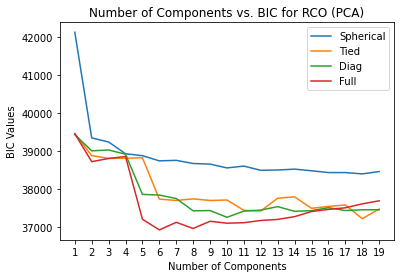

In [207]:
plt.figure()
plt.plot(num_components_values, bic[0], label = 'Spherical')
plt.plot(num_components_values, bic[1], label = 'Tied')
plt.plot(num_components_values, bic[2], label = 'Diag')
plt.plot(num_components_values, bic[3], label = 'Full')
plt.legend()
plt.xticks(num_components_values)
plt.title("Number of Components vs. BIC for RCO (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("BIC Values")
plt.savefig('rice_bic_pca.png')
plt.show()

Silhouette score:  0.07432920111178859
Adjusted Mutual Information (AMI) score:  0.2062119903522036


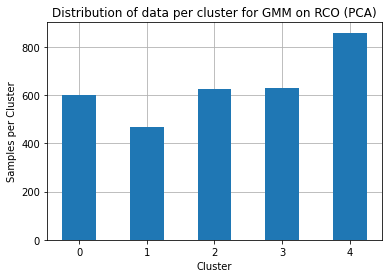

In [208]:
gmm_labels = best_gmm.predict(X_PCA)
silhouette_score_value = silhouette_score(X_PCA, gmm_labels)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, gmm_labels)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(gmm_labels, bins=np.arange(0, 6) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, 5))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for GMM on RCO (PCA)')
plt.grid()

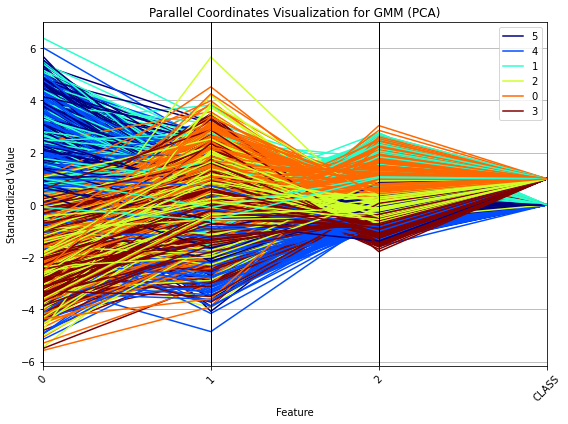

In [209]:
np.random.seed(40)
data_viz = pd.DataFrame(X_PCA)
data_viz['CLASS'] = y
data_viz['cluster_class'] = gmm_labels

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1])

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for GMM (PCA)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_gmm_pca.png')

In [210]:
for i in range(max(gmm_labels)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

1    573
0     29
Name: CLASS, dtype: int64
0    401
1     68
Name: CLASS, dtype: int64
1    584
0     40
Name: CLASS, dtype: int64
1    623
0      6
Name: CLASS, dtype: int64
0    573
1    286
Name: CLASS, dtype: int64
0    581
1     46
Name: CLASS, dtype: int64


In [223]:
573/(573+286)

0.6670547147846333

Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 7
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for spherical 11
Lowest BIC currently for spherical 12
Lowest BIC currently for spherical 13
Lowest BIC currently for spherical 14
Lowest BIC currently for spherical 16
Lowest BIC currently for spherical 17
Lowest BIC currently for spherical 18
Lowest BIC currently for spherical 19
Lowest BIC currently for tied 10
Lowest BIC currently for tied 13
Lowest BIC currently for tied 14
Lowest BIC currently for tied 18
Lowest BIC currently for tied 19
Lowest BIC currently for diag 6
Lowest BIC currently for diag 7
Lowest BIC currently for diag 8
Lowest BIC currently for diag 9
Lowest BIC currently for diag 10

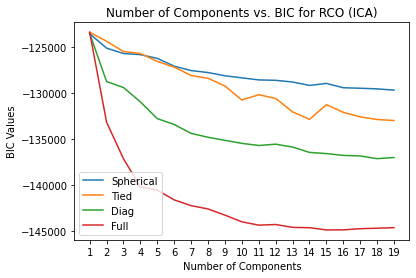

In [211]:
lowest_bic = np.infty
num_components_values = range(1, 20)
covariances = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(covariances),len(num_components_values)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(X_ICA)
        bic[i][j] = gmm.bic(X_ICA)
        if bic[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm = gmm

plt.figure()
plt.plot(num_components_values, bic[0], label = 'Spherical')
plt.plot(num_components_values, bic[1], label = 'Tied')
plt.plot(num_components_values, bic[2], label = 'Diag')
plt.plot(num_components_values, bic[3], label = 'Full')
plt.legend()
plt.xticks(num_components_values)
plt.title("Number of Components vs. BIC for RCO (ICA)")
plt.xlabel("Number of Components")
plt.ylabel("BIC Values")
plt.savefig('rice_bic_ica.png')
plt.show()

Silhouette score:  0.045248180779447256
Adjusted Mutual Information (AMI) score:  0.16621254980251826


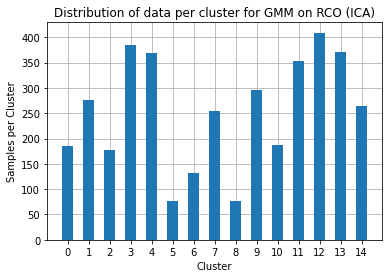

In [212]:
gmm_labels = best_gmm.predict(X_ICA)
silhouette_score_value = silhouette_score(X_ICA, gmm_labels)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, gmm_labels)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(gmm_labels, bins=np.arange(0, 16) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, 15))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for GMM on RCO (ICA)')
plt.grid()

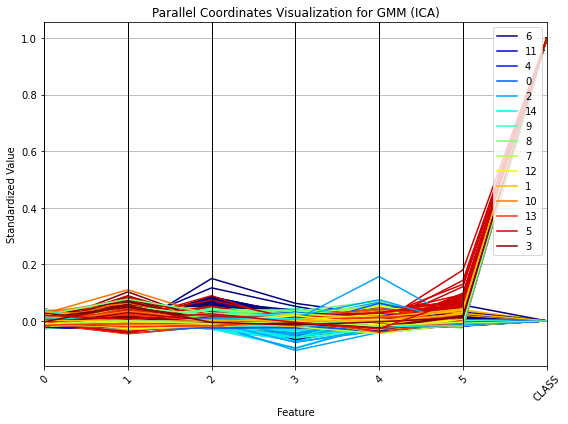

In [213]:
np.random.seed(40)
data_viz = pd.DataFrame(X_ICA)
data_viz['CLASS'] = y
data_viz['cluster_class'] = gmm_labels

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1])

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for GMM (ICA)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_gmm_ica.png')

In [214]:
for i in range(max(gmm_labels)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

1    94
0    92
Name: CLASS, dtype: int64
1    267
0      9
Name: CLASS, dtype: int64
0    173
1      4
Name: CLASS, dtype: int64
1    384
Name: CLASS, dtype: int64
0    348
1     20
Name: CLASS, dtype: int64
1    77
Name: CLASS, dtype: int64
0    131
Name: CLASS, dtype: int64
1    224
0     31
Name: CLASS, dtype: int64
1    38
0    38
Name: CLASS, dtype: int64
0    288
1      8
Name: CLASS, dtype: int64
1    171
0     16
Name: CLASS, dtype: int64
0    264
1     90
Name: CLASS, dtype: int64
1    385
0     24
Name: CLASS, dtype: int64
1    367
0      3
Name: CLASS, dtype: int64
0    213
1     51
Name: CLASS, dtype: int64


Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 7
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for spherical 11
Lowest BIC currently for spherical 12
Lowest BIC currently for spherical 13
Lowest BIC currently for spherical 14
Lowest BIC currently for spherical 15
Lowest BIC currently for spherical 16
Lowest BIC currently for spherical 17
Lowest BIC currently for spherical 18
Lowest BIC currently for tied 1
Lowest BIC currently for tied 2
Lowest BIC currently for tied 3
Lowest BIC currently for tied 4
Lowest BIC currently for tied 6
Lowest BIC currently for tied 7
Lowest BIC currently for tied 9
Lowest BIC currently for tied 10
Lowest BIC currently for tied 11
Lowest BIC currently for tied 15
Lo

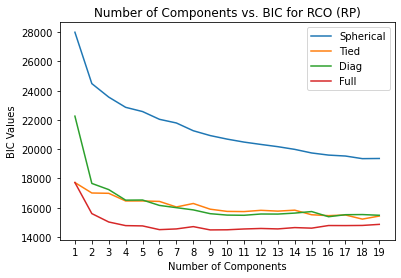

In [215]:
lowest_bic = np.infty
num_components_values = range(1, 20)
covariances = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(covariances),len(num_components_values)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(X_RP)
        bic[i][j] = gmm.bic(X_RP)
        if bic[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm = gmm

plt.figure()
plt.plot(num_components_values, bic[0], label = 'Spherical')
plt.plot(num_components_values, bic[1], label = 'Tied')
plt.plot(num_components_values, bic[2], label = 'Diag')
plt.plot(num_components_values, bic[3], label = 'Full')
plt.legend()
plt.xticks(num_components_values)
plt.title("Number of Components vs. BIC for RCO (RP)")
plt.xlabel("Number of Components")
plt.ylabel("BIC Values")
plt.savefig('rice_bic_rp.png')
plt.show()

Silhouette score:  0.009597311753058805
Adjusted Mutual Information (AMI) score:  0.18976683161282815


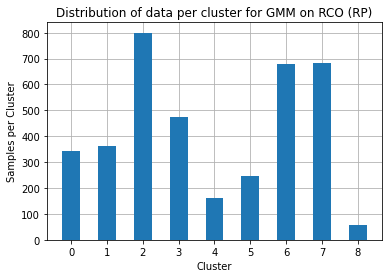

In [216]:
gmm_labels = best_gmm.predict(X_RP)
silhouette_score_value = silhouette_score(X_RP, gmm_labels)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, gmm_labels)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(gmm_labels, bins=np.arange(0, 10) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, 9))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for GMM on RCO (RP)')
plt.grid()

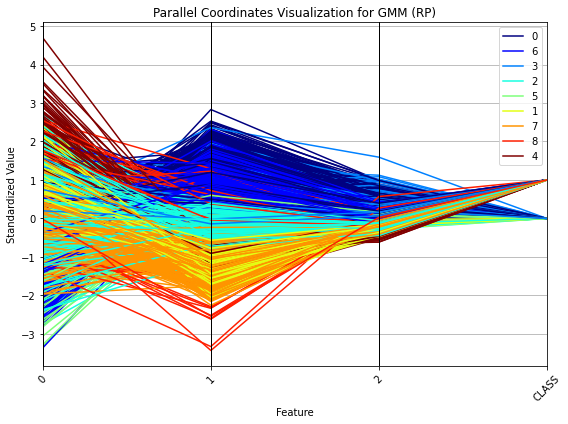

In [217]:
np.random.seed(40)
data_viz = pd.DataFrame(X_RP)
data_viz['CLASS'] = y
data_viz['cluster_class'] = gmm_labels

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1])

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for GMM (RP)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_gmm_rp.png')

In [218]:
for i in range(max(gmm_labels)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

0    307
1     36
Name: CLASS, dtype: int64
1    328
0     34
Name: CLASS, dtype: int64
1    728
0     72
Name: CLASS, dtype: int64
0    409
1     67
Name: CLASS, dtype: int64
1    150
0     10
Name: CLASS, dtype: int64
0    236
1     11
Name: CLASS, dtype: int64
0    548
1    132
Name: CLASS, dtype: int64
1    677
0      6
Name: CLASS, dtype: int64
1    51
0     8
Name: CLASS, dtype: int64


In [224]:
548/(548+132)

0.8058823529411765

Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 7
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for spherical 11
Lowest BIC currently for spherical 12
Lowest BIC currently for spherical 13
Lowest BIC currently for spherical 14
Lowest BIC currently for spherical 15
Lowest BIC currently for spherical 16
Lowest BIC currently for spherical 17
Lowest BIC currently for spherical 18
Lowest BIC currently for spherical 19
Lowest BIC currently for tied 1
Lowest BIC currently for tied 2
Lowest BIC currently for tied 3
Lowest BIC currently for tied 4
Lowest BIC currently for tied 5
Lowest BIC currently for tied 11
Lowest BIC currently for full 2
Lowest BIC currently for full 3
Lowest BIC currently for full 

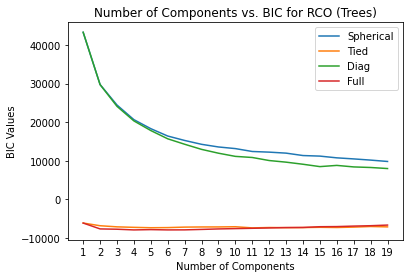

In [219]:
lowest_bic = np.infty
num_components_values = range(1, 20)
covariances = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(covariances),len(num_components_values)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(X_Trees)
        bic[i][j] = gmm.bic(X_Trees)
        if bic[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm = gmm

plt.figure()
plt.plot(num_components_values, bic[0], label = 'Spherical')
plt.plot(num_components_values, bic[1], label = 'Tied')
plt.plot(num_components_values, bic[2], label = 'Diag')
plt.plot(num_components_values, bic[3], label = 'Full')
plt.legend()
plt.xticks(num_components_values)
plt.title("Number of Components vs. BIC for RCO (Trees)")
plt.xlabel("Number of Components")
plt.ylabel("BIC Values")
plt.savefig('rice_bic_trees.png')
plt.show()

Silhouette score:  0.04858212266234595
Adjusted Mutual Information (AMI) score:  0.31360018019580066


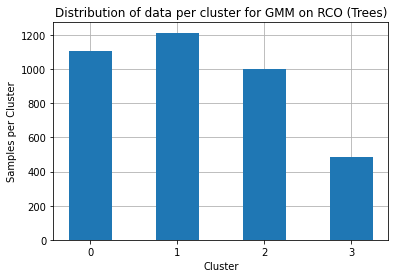

In [220]:
gmm_labels = best_gmm.predict(X_Trees)
silhouette_score_value = silhouette_score(X_Trees, gmm_labels)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(y, gmm_labels)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(gmm_labels, bins=np.arange(0, 5) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, 4))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for GMM on RCO (Trees)')
plt.grid()

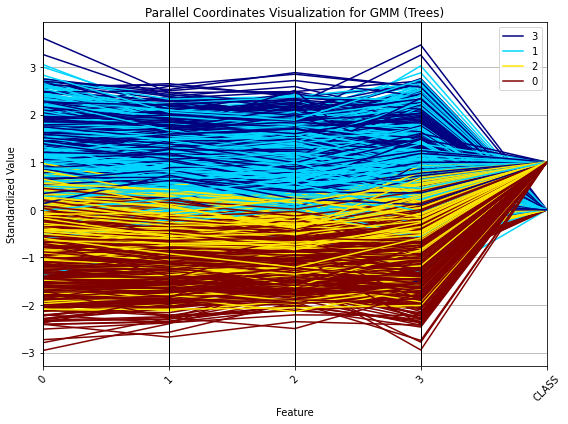

In [221]:
np.random.seed(40)
data_viz = pd.DataFrame(X_Trees)
data_viz['CLASS'] = y
data_viz['cluster_class'] = gmm_labels

idx_viz = np.append(np.arange(0, data_viz.shape[1] - 2), [data_viz.shape[1] - 2, data_viz.shape[1] - 1])

plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data_viz.iloc[:, idx_viz], 'cluster_class', colormap='jet')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Standardized Value')
plt.title('Parallel Coordinates Visualization for GMM (Trees)')
plt.tight_layout()
plt.savefig('rice_parallel_coordinates_gmm_trees.png')

In [222]:
for i in range(max(gmm_labels)+1):
    print(data[data_viz['cluster_class'] == i]['CLASS'].value_counts())

1    1092
0      14
Name: CLASS, dtype: int64
0    1056
1     158
Name: CLASS, dtype: int64
1    897
0    105
Name: CLASS, dtype: int64
0    455
1     33
Name: CLASS, dtype: int64
